In [1]:
from femdvr import FEMDVR
from lobatto import GaussLegendreLobatto
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import kron, csr_matrix, diags
from scipy.sparse.linalg import eigs


In [2]:
L = 10
n_points = 10
n_elem = 4
elem_nodes = np.linspace(-L, L, 2*n_elem + 1)
femdvr0 = FEMDVR(elem_nodes, np.array([n_points] * 2 * n_elem), GaussLegendreLobatto)
print(femdvr0.x)
x = femdvr0.x
ng = len(x)
print(ng)
print(x[ng//2])


[-10.          -9.89941739  -9.67346733  -9.34740619  -8.9565987
  -8.5434013   -8.15259381  -7.82653267  -7.60058261  -7.5
  -7.39941739  -7.17346733  -6.84740619  -6.4565987   -6.0434013
  -5.65259381  -5.32653267  -5.10058261  -5.          -4.89941739
  -4.67346733  -4.34740619  -3.9565987   -3.5434013   -3.15259381
  -2.82653267  -2.60058261  -2.5         -2.39941739  -2.17346733
  -1.84740619  -1.4565987   -1.0434013   -0.65259381  -0.32653267
  -0.10058261   0.           0.10058261   0.32653267   0.65259381
   1.0434013    1.4565987    1.84740619   2.17346733   2.39941739
   2.5          2.60058261   2.82653267   3.15259381   3.5434013
   3.9565987    4.34740619   4.67346733   4.89941739   5.
   5.10058261   5.32653267   5.65259381   6.0434013    6.4565987
   6.84740619   7.17346733   7.39941739   7.5          7.60058261
   7.82653267   8.15259381   8.5434013    8.9565987    9.34740619
   9.67346733   9.89941739  10.        ]
73
0.0


In [13]:

origin = np.where((x == 0))[0]
print("Origin index:", origin)
index_dirichlet = np.where((x == -L) | (x == L))[0]
#index_dirichlet = np.where(((x_vec == 0) & (y_vec == 0)) | (x_vec == -L) | (x_vec == L) | (y_vec == L) | (y_vec == -L))[0]
#index_dirichlet = np.where( ((xx == -L) | (xx == L) | (yy == -L) | (yy == L) | (zz == -L) | (zz == L)))[0]

print('Boundary index: ', index_dirichlet)

index_dirichlet_and_origin = np.union1d(index_dirichlet, origin)
print('Boundary and origin index: ', index_dirichlet_and_origin)

Origin index: [36]
Boundary index:  [ 0 72]
Boundary and origin index:  [ 0 36 72]


In [14]:
# remove Dirichlet boundary conditions
def crop(H, p):
    """Remove rows and columns corresponding to Dirichlet boundary conditions."""
    q = p
    n_rows, n_cols = H.shape
    row_mask = np.ones(n_rows, dtype=bool)
    col_mask = np.ones(n_cols, dtype=bool)

    row_mask[p] = False
    col_mask[q] = False

    return H[row_mask][:, col_mask]

def crop_vec(psi, p):
    """Remove elements corresponding to Dirichlet boundary conditions."""
    return psi[np.setdiff1d(np.arange(len(psi)), p)]



def insert_zeros(psi, p):
    """Insert zeros into the wavefunction at the Dirichlet boundary conditions."""
    n = psi.shape[0]
    psi_new = np.zeros(n + len(p), dtype=psi.dtype)
    psi_new[np.setdiff1d(np.arange(n + len(p)), p)] = psi
    return psi_new


In [15]:
T0 = -0.5 * csr_matrix(femdvr0.D2)
D0 = csr_matrix(femdvr0.D)
I0 = csr_matrix(np.eye(ng))

#V = diags([0.5 * (xxx**2 + yyy**2 + zzz**2)], [0], shape=T.shape)

V0 = diags([x**2/2], [0], shape=(ng,ng))

H0 = T0 + V0

H1 = crop(H0, index_dirichlet)
H2 = crop(H0, index_dirichlet_and_origin)

print("H shape:", H0.shape)
print("H1 shape:", H1.shape)
print("H2 shape:", H2.shape)

H shape: (73, 73)
H1 shape: (71, 71)
H2 shape: (70, 70)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

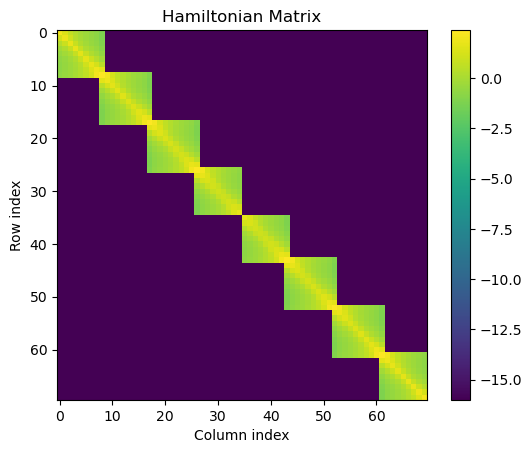

In [16]:
plt.figure()
# vmin = np.min(H.toarray())
# vmax = np.max(H.toarray())
# print("H min:", vmin, "H max:", vmax)
# vminmax = max(abs(vmin), abs(vmax))
plt.imshow(np.log10(np.abs(H2.toarray()) + 1e-16), cmap='viridis', aspect='equal')
#plt.spy(H, markersize=1)
plt.colorbar()
plt.title('Hamiltonian Matrix')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()


In [21]:
energy_vec, psi_mat = eigs(H1, k=10, which='SR')
energy_vec

array([0.5       +0.j, 1.5       +0.j, 2.49999988+0.j, 3.50000104+0.j,
       4.4999937 +0.j, 5.50002006+0.j, 6.49994513+0.j, 7.50004988+0.j,
       8.50001976+0.j, 9.49935516+0.j])

In [22]:
energy_vec0, psi_mat0 = eigs(H2, k=10, which='SR')
energy_vec0

array([1.5       +0.j, 1.5       +0.j, 3.50000104+0.j, 3.50000104+0.j,
       5.50002006+0.j, 5.50002006+0.j, 7.50004988+0.j, 7.50004988+0.j,
       9.49935516+0.j, 9.49935516+0.j])

In [23]:
j = 0
psi = psi_mat[:, j]

psi at origon = (-0.0033988489973867816+0j)


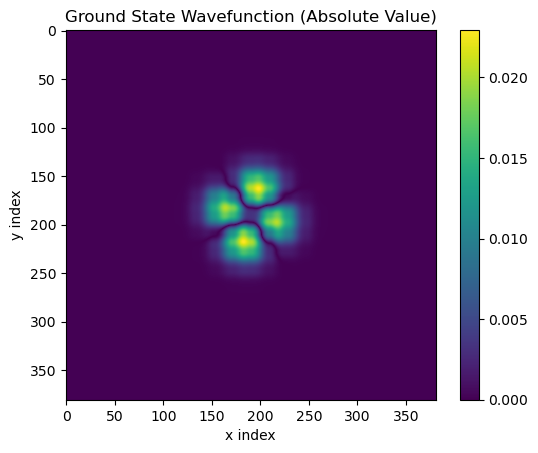

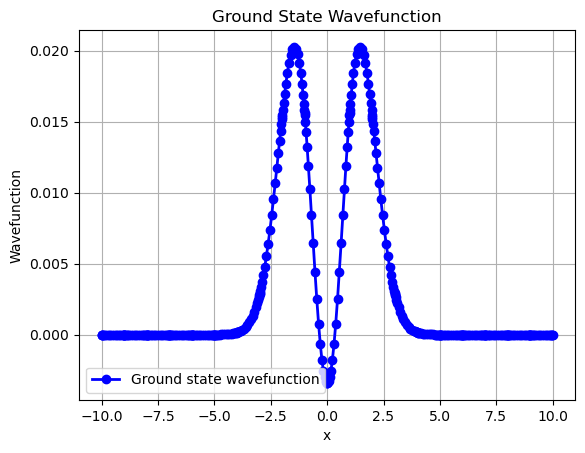

In [24]:
psi = insert_zeros(psi_mat[:,5], index_dirichlet).reshape((ng, ng))
print(f"psi at origon = {psi[ng//2, ng//2]}")

plt.figure()
plt.imshow(np.abs(psi), cmap='viridis', aspect='equal')
plt.colorbar()
plt.title('Ground State Wavefunction (Absolute Value)')
plt.xlabel('x index')
plt.ylabel('y index')
plt.show()


plt.figure()
plt.plot(x, psi[:,ng//2], label='Ground state wavefunction', color='blue', linewidth=2, marker='o')
plt.title('Ground State Wavefunction')
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid()
plt.show()

In [30]:
H = np.random.rand(5,5)
print(H)
idx = np.array([0, 2, 4])
print(crop(H, idx))

[[0.79377831 0.07449012 0.87889351 0.07498835 0.02448544]
 [0.27916373 0.75233257 0.53684086 0.53757715 0.08009134]
 [0.46826915 0.82250399 0.85592565 0.45798835 0.71473474]
 [0.24206936 0.83681843 0.68545509 0.60670316 0.42384067]
 [0.71501772 0.69481824 0.19290264 0.61050651 0.58920627]]
[[0.75233257 0.53757715]
 [0.83681843 0.60670316]]


In [31]:
P = np.eye(5)
P = P[:, np.setdiff1d(np.arange(5), idx)]
print(P)
print(P.T @ H @ P - crop(H, idx))

[[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
